In [1]:
# Importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import compose

from plotnine import *

%matplotlib inline

In [2]:
#Loading our cleaned dataset
df = pd.read_csv('data/cleaned_df_v2.csv')

In [3]:
#df.isnull().sum()
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,longitude,latitude,basin,region,district_code,...,extraction_type_class,management,payment_type,water_quality,quantity,source,source_class,waterpoint_type,status_group,pump_age
0,69572,6000.0,2011-03-14,roman,1390.000000,34.938093,-9.856322,lake nyasa,iringa,5,...,gravity,vwc,annually,soft,enough,spring,groundwater,communal standpipe,functional,12.0
1,8776,200.0,2013-03-06,grumeti,1399.000000,34.698766,-2.147466,lake victoria,mara,2,...,gravity,wug,never pay,soft,insufficient,rainwater harvesting,surface,communal standpipe,functional,3.0
2,34310,25.0,2013-02-25,lottery club,686.000000,37.460664,-3.821329,pangani,manyara,4,...,gravity,vwc,per bucket,soft,enough,dam,surface,communal standpipe multiple,functional,4.0
3,67743,50.0,2013-01-28,unicef,263.000000,38.486161,-11.155298,ruvuma / southern coast,mtwara,63,...,submersible,vwc,never pay,soft,dry,machine dbh,groundwater,communal standpipe multiple,non functional,27.0
4,19728,250.0,2011-07-13,action in a,1057.545585,31.130847,-1.825359,lake victoria,kagera,1,...,gravity,other,never pay,soft,seasonal,rainwater harvesting,surface,communal standpipe,functional,11.0


In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list(df.select_dtypes(include=numerics))

['id',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'district_code',
 'population',
 'construction_year',
 'pump_age']

It could be useful to observe the distribution of a few of these variables. Here is a list of a few variables in train that you could view in this way:

amount_tsh - Total static head (amount water available to water point)
gps_height - Altitude of the well
population - Population around the well
construction_year - Year the water point was constructed

In [5]:
from scipy.stats import norm
from scipy.stats import t
from numpy.random import seed

In [6]:
# Manually calculating the Standard Deviation
diff = df.pump_age - np.mean(df.pump_age)
diff_squared = diff **2
v = (np.sum(diff_squared))/len(df.pump_age)

np.sqrt(v)

10.260620069060742

In [7]:
# Using the square root (np.sqrt()) of the variance (np.var()) to calculate the Standard Deviation
print('Mean:', np.mean(df.pump_age))
np.std(df.pump_age)

Mean: 13.996464646464647


10.260620069060963

In [8]:
print('Mean:', np.mean(df.pump_age))
np.std(df.pump_age)

Mean: 13.996464646464647


10.260620069060963

In [9]:
def age_sampler(n):
    return np.random.choice(df.pump_age, n)

In [10]:
seed(47)
age_sample1 = age_sampler(1000)

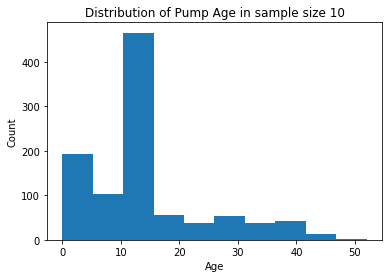

In [11]:
_ = plt.hist(age_sample1, bins=10)
_ = plt.xlabel('Age')
_ = plt.ylabel('Count')
_ = plt.title('Distribution of Pump Age in sample size 10')

In [12]:
norm.cdf(x=df.pump_age, loc=np.mean(df.pump_age), scale=5)

array([0.34483869, 0.01392855, 0.02278833, ..., 0.27448878, 0.27448878,
       0.1588264 ])

In [13]:
max(df.pump_age)

53.0

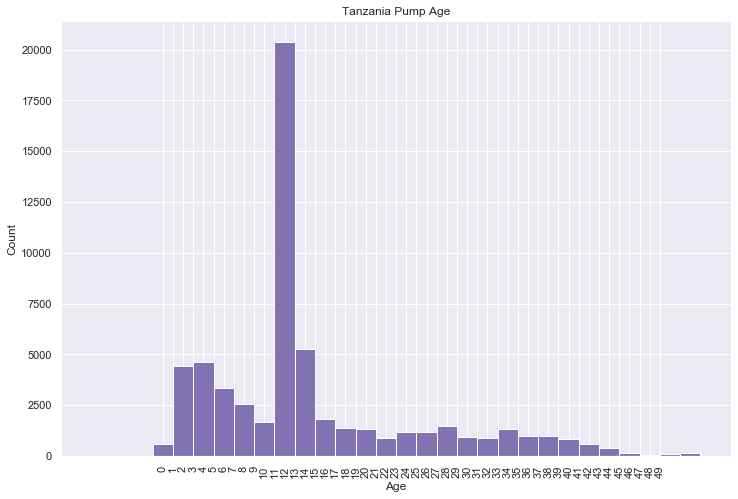

In [14]:
sns.set()
plt.figure(figsize=[12,8])
plt.hist(df.pump_age, bins = 30, color='C4')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Tanzania Pump Age')
plt.xticks(range(0,50,1), rotation = 'vertical')
plt.show()

In [15]:
print('The mean of the pump age is {} '.format(round(np.mean(df.pump_age),2)))
print('The standard deviation of the pump age is {} '.format(round(np.std(df.pump_age),2)))

The mean of the pump age is 14.0 
The standard deviation of the pump age is 10.26 


In [16]:
n = len(df.pump_age)
dof = n - 1
p = 0.95
critical_t = t.ppf(p, dof)
print('The critical t value for one tailed 95% confidence interval is: {} '.format(critical_t))

The critical t value for one tailed 95% confidence interval is: 1.6448792804651238 


In [17]:
# Standard Error of the Mean (a.k.a. the standard deviation of the sampling distribution of the sample mean!
se = (np.std(df.pump_age)) / (np.sqrt(n))
moe = critical_t * se # Margin of Error
print('The Margin of error is: {} '.format(moe))

The Margin of error is: 0.06924914480418964 


In [25]:
lower = (np.mean(df.pump_age)) - moe
lower

13.927215501660458

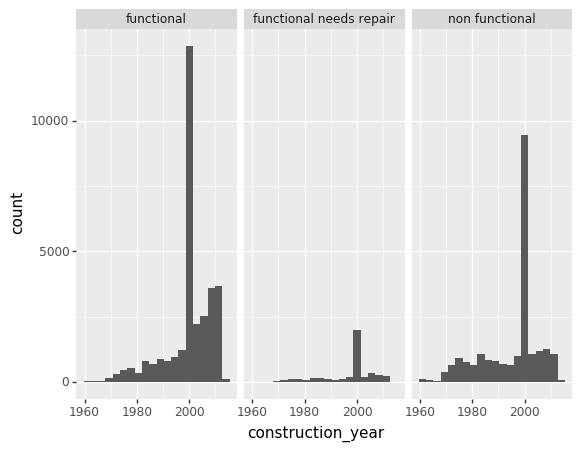

<ggplot: (-9223371938301592944)>

In [19]:
(ggplot(df)
 + aes(x = 'construction_year')
 + geom_histogram(bins = 20)
 + facet_grid('~ status_group'))

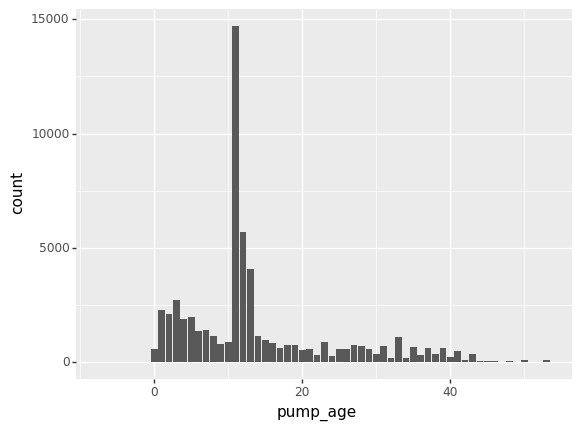

<ggplot: (-9223371938301484000)>

In [27]:
(ggplot(df)         # defining what data to use
 +aes(x='pump_age')    # defining what variable to use
 +geom_bar(size=5) # defining the type of plot to use
)

In [21]:
#(ggplot(df, 'latitude < 0 & longitude > 0'), 
#        aes(x = latitude, y = longitude, color = status_group)) + geom_point(shape = 1)

In [22]:
np.random.seed(47)
N_rep = 10000

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))


def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

bs_replicates = draw_bs_reps(df.pump_age, np.mean, N_rep)
# I think because we have a one sided test, we need to use 5 instead of the range between (2.5, 97.5)?
conf_int = np.percentile(bs_replicates,(5)) 
conf_int

13.925554713804715

In [39]:
functional_age = df.loc[df.status_group == 'functional', 'pump_age']
nonfunctional_age = df.loc[df.status_group == 'non functional', 'pump_age']

In [40]:
print('std for functional_age:' , np.std(functional_age, ddof=1))
print('std for nonfunctional_age:' , np.std(nonfunctional_age, ddof=1))

std for functional_age: 8.955299315445076
std for nonfunctional_age: 11.323072591249913


In [44]:
np.random.seed(47)
N_rep = 10000

def std_diff(data1, data2):
    return np.std(data1) - np.std(data2) 

def draw_bs_reps1(data1, data2, size):
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
    
    # Generate replicates
    for i in range(size):
        dt1 = np.random.choice(data1, size=len(data1))
        dt2 = np.random.choice(data2, size=len(data2))
        bs_replicates[i] = std_diff(dt1, dt2)

    return bs_replicates

bs_replicates = draw_bs_reps1(functional_age, nonfunctional_age, N_rep)

In [45]:
conf_int = np.percentile(bs_replicates,(2.5, 97.5)) 
conf_int

array([-2.51653839, -2.22333019])

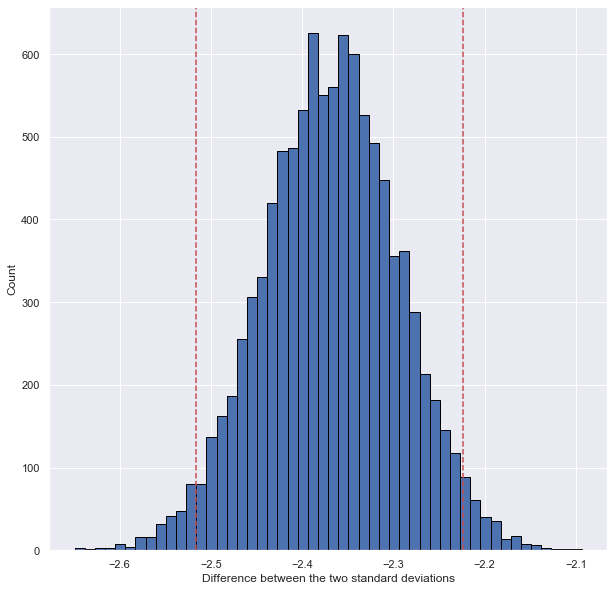

In [46]:
plt.figure(figsize=(10,10))
plt.hist(bs_replicates,bins=50, edgecolor ='black')
plt.xlabel('Difference between the two standard deviations')
plt.ylabel('Count')
plt.axvline(conf_int[0],linestyle='--',color='r')
plt.axvline(conf_int[1],linestyle='--',color='r')
plt.show()

In [47]:
# Compute the difference of the means: mean_diff
mean_diff = np.mean(functional_age) - np.mean(nonfunctional_age)

# Compute mean of combined charges: combined_mean
combined_mean = np.mean(np.concatenate((functional_age, nonfunctional_age)))

# Shift the samples
functional_age_shifted = functional_age - np.mean(functional_age) + combined_mean
nonfunctional_age_shifted = nonfunctional_age - np.mean(nonfunctional_age) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_functional_age = draw_bs_reps(functional_age_shifted, np.mean, 10000)
bs_replicates_nonfunctional_age = draw_bs_reps(nonfunctional_age_shifted, np.mean, 10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_functional_age - bs_replicates_nonfunctional_age

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 1.0


In [48]:
conf_int = np.percentile(bs_diff_replicates,(2.5, 97.5)) 
conf_int

array([-0.17226914,  0.1785553 ])

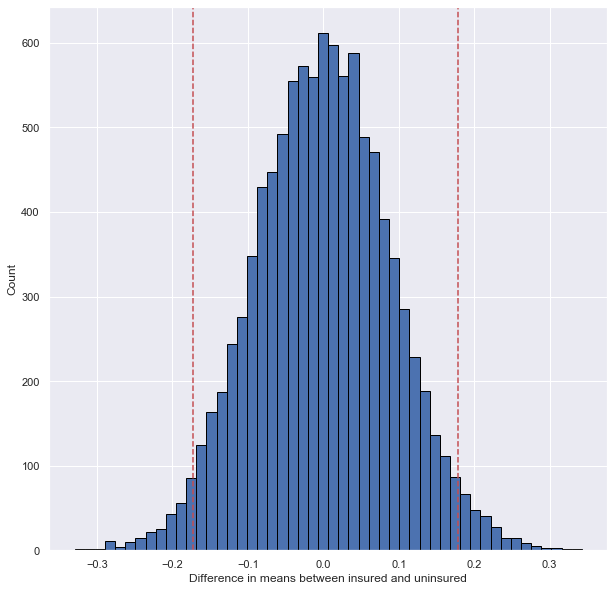

In [49]:
# Plotting in histogram
plt.figure(figsize=(10,10))
plt.hist(bs_diff_replicates,bins=50, edgecolor ='black')
plt.xlabel('Difference in means between insured and uninsured')
plt.ylabel('Count')
plt.axvline(conf_int[0],linestyle='--',color='r')
plt.axvline(conf_int[1],linestyle='--',color='r')
plt.show()